In [2]:
import pandas as pd
import numpy as np
# import lifelines as ll
# import sksurv as sks
import matplotlib.pyplot as plt
from bart_survival import surv_bart as sb
from bart_survival import simulation as sm
# import lifelines as ll
# from lifelines import KaplanMeierFitter
import subprocess
import importlib

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [58]:
import sys
sys.path.append("../py/")
import _conditions1 as cn
import _functions1 as fn
import _sim_iter1 as si
import _plot_fx as pltf

In [91]:
reg_1 = {
    "type": "Simple, 1 group, 20% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[1],
    "scale_f": "7*x_mat[:,0]",
    "shape_f": "3",
    # "cens_scale":7
	"cens_scale":1.3
}

In [109]:
SPLIT_RULES =  [
    "pmb.ContinuousSplitRule()", 
    # "pmb.ContinuousSplitRule()", 
    # "pmb.OneHotSplitRule()"
]
model_dict = {"trees": 25,
    "split_rules": SPLIT_RULES
}
sampler_dict = {
            "draws": 400,
            "tune": 10,
            "cores": 5,
            "chains": 5,
            "compute_convergence_checks": False
        }

In [110]:
importlib.reload(fn)
c = []
for i in range(1):
	meta, sv_true, k_sv, p_sv, r_sv  = fn.sim_1s(
	# cens= fn.sim_1s(
		i, 
		100,
		reg_1, 
		SPLIT_RULES, 
		model_dict, 
		sampler_dict
	)
	# c.append(cens)



mean shape 3.0
mean scale 7.0
13.0
mean time draws 5.89398967915927
cens mean 10.45
[[3]
 [5]
 [6]
 [8]
 [9]]


Only 400 samples in chain.
Multiprocess sampling (5 chains in 5 jobs)
PGBART: [f]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 5 chains for 10 tune and 400 draw iterations (50 + 2_000 draws total) took 23 seconds.
Sampling: [f]


Loading required package: nlme
Loading required package: nnet
Loading required package: survival


[1] "/Users/jacobtiegs/projects/bart_paper/bart_survival_paper/notebook"
*****Calling gbart: type=2
*****Data:
data:n,p,np: 241, 1, 5
y1,yn: 0.000000, 1.000000
x1,x[n*p]: 3.000000, 5.000000
xp1,xp[np*p]: 3.000000, 9.000000
*****Number of Trees: 50
*****Number of Cut Points: 4 ... 4
*****burn,nd,thin: 250,1670,10
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.212132,3,1,-0.664729
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,1,0
*****printevery: 100

MCMC
done 0 (out of 1920)
done 100 (out of 1920)
done 200 (out of 1920)
done 300 (out of 1920)
done 400 (out of 1920)
done 500 (out of 1920)
done 600 (out of 1920)
done 700 (out of 1920)
done 800 (out of 1920)
done 900 (out of 1920)
done 1000 (out of 1920)
done 1100 (out of 1920)
done 1200 (out of 1920)
done 1300 (out of 1920)
done 1400 (out of 1920)
done 1500 (out of 1920)
done 1600 (out of 1920)
done 1700 (out of 1920)
done 1800 (out of 1920)
done 1900 (out of 1920)
time: 1s
trcnt,tecnt: 167,167


[]

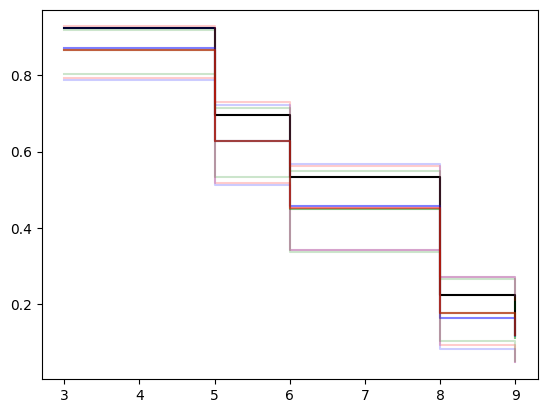

In [112]:
msk = meta[2].astype(int)-1
plt.step(meta[1][msk], sv_true[msk], color = "black", where="post")
# print(meta[1][meta[2].astype(int)])

plt.step(k_sv[2], k_sv[0], where="post", color="blue", alpha=0.5)
plt.step(k_sv[2], k_sv[1][0],where="post", color="blue", alpha=0.2)
plt.step(k_sv[2], k_sv[1][1],where="post", color="blue", alpha=0.2)

plt.step(p_sv[1], p_sv[0][0], where="post", color="green", alpha=0.5)
plt.step(p_sv[1], p_sv[0][1][0],where="post", color="green", alpha=0.2)
plt.step(p_sv[1], p_sv[0][1][1],where="post", color="green", alpha=0.2)

plt.step(p_sv[1], r_sv[0], where="post", color="red", alpha=0.5)
plt.step(p_sv[1], r_sv[1][0],where="post", color="red", alpha=0.2)
plt.step(p_sv[1], r_sv[1][1],where="post", color="red", alpha=0.2)
# k_sv[1]

# type 2

In [292]:
SPLIT_RULES =  [
    "pmb.ContinuousSplitRule()", 
    # "pmb.ContinuousSplitRule()", 
    "pmb.OneHotSplitRule()"
]
model_dict = {"trees": 30,
    "split_rules": SPLIT_RULES
}
sampler_dict = {
            "draws": 500,
            "tune": 30,
            "cores": 5,
            "chains": 5,
            "compute_convergence_checks": False
        }

In [287]:
reg_1 = {
    "type": "Simple, 2 group, 20% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[.5],
    "scale_f": "12 - .5 *x_mat[:,0]",
    "shape_f": "1.2 + 1 *x_mat[:,0]",
    "cens_scale":5.9
	# "cens_scale":1.1
}

In [293]:
importlib.reload(si)
meta, cens,k,p,r,fig = si.iter_simulation_2s(
	iters=1, 
	n=200,
	# scenario= cn.simple_1_1, 
	scenario=reg_1,
	SPLIT_RULES=SPLIT_RULES, 
	model_dict=model_dict, 
	sampler_dict=sampler_dict
)

mean shape 1.7399999999999993
mean scale 11.73
49.0
mean time draws 10.544746869353999
cens mean 68.125
[ 3  6  9 14 19]


Multiprocess sampling (5 chains in 5 jobs)
PGBART: [f]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Sampling 5 chains for 30 tune and 500 draw iterations (150 + 2_500 draws total) took 57 seconds.
Sampling: [f]


Loading required package: nlme
Loading required package: nnet
Loading required package: survival


[1] "/Users/jacobtiegs/projects/bart_paper/bart_survival_paper/notebook"
*****Calling gbart: type=2
*****Data:
data:n,p,np: 628, 2, 10
y1,yn: 0.000000, 1.000000
x1,x[n*p]: 3.000000, 1.000000
xp1,xp[np*p]: 3.000000, 1.000000
*****Number of Trees: 50
*****Number of Cut Points: 4 ... 1
*****burn,nd,thin: 250,1670,10
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.212132,3,1,-0.654579
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,2,0
*****printevery: 100

MCMC
done 0 (out of 1920)
done 100 (out of 1920)
done 200 (out of 1920)
done 300 (out of 1920)
done 400 (out of 1920)
done 500 (out of 1920)
done 600 (out of 1920)
done 700 (out of 1920)
done 800 (out of 1920)
done 900 (out of 1920)
done 1000 (out of 1920)
done 1100 (out of 1920)
done 1200 (out of 1920)
done 1300 (out of 1920)
done 1400 (out of 1920)
done 1500 (out of 1920)
done 1600 (out of 1920)
done 1700 (out of 1920)
done 1800 (out of 1920)
done 1900 (out of 1920)
time: 3s
trcnt,tecnt: 167,167
[0.82740203 0.64708

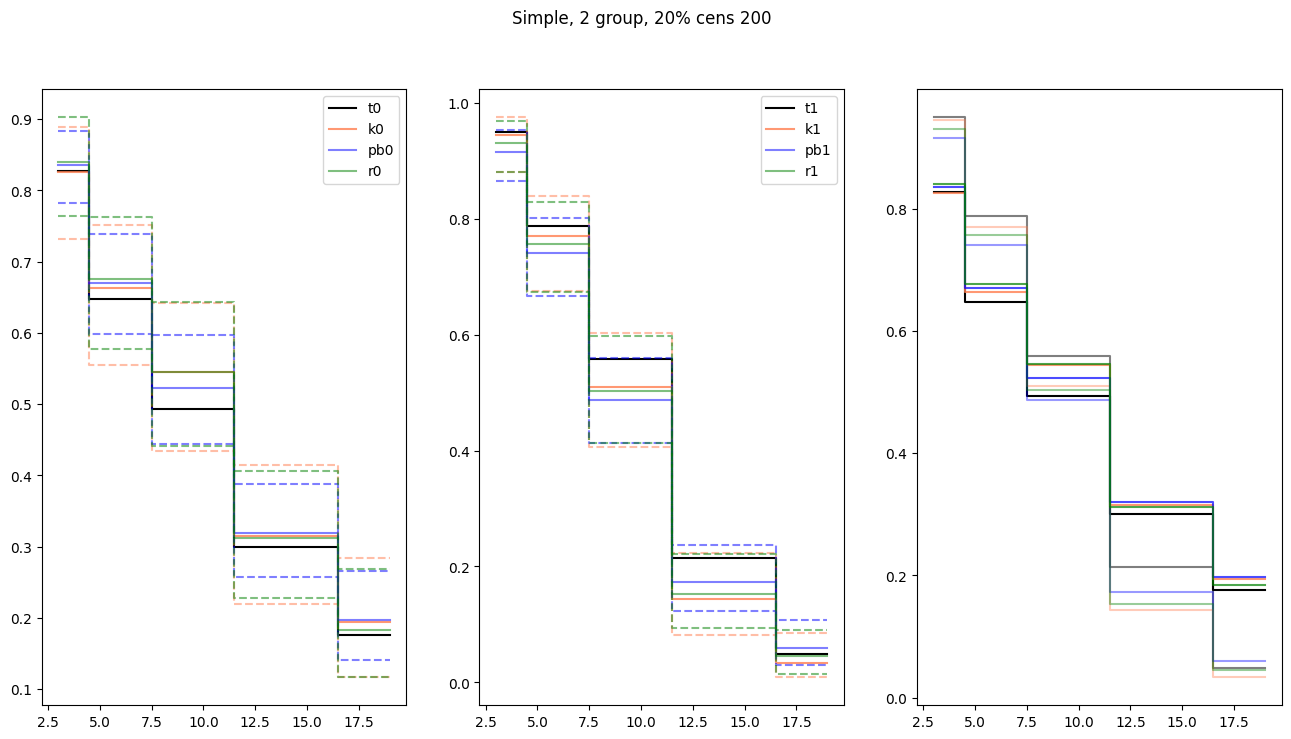

In [294]:
fig
# meta[0][3][0]

In [295]:
# sv_true
k, p, r

({'rmse': array([0.00309246, 0.0171692 , 0.05048506, 0.04231969, 0.01655406]),
  'bias': array([ 0.00309246,  0.00105914, -0.00168742,  0.02779782, -0.00087325]),
  'cov': array([1., 1., 1., 1., 1.]),
  'ivl': array([0.12591857, 0.18007275, 0.2019618 , 0.16893349, 0.12199333])},
 {'rmse': array([0.02122475, 0.03497457, 0.05049195, 0.02985744, 0.01600457]),
  'bias': array([ 0.01301141,  0.01137866,  0.02040057,  0.01083331, -0.01600457]),
  'cov': array([1., 1., 1., 1., 1.]),
  'ivl': array([0.09500013, 0.13651308, 0.15017493, 0.12251074, 0.10088769])},
 {'rmse': array([0.01588508, 0.03018365, 0.05364043, 0.0364225 , 0.00578708]),
  'bias': array([ 0.00333665,  0.00099717,  0.00117577,  0.02468471, -0.00168957]),
  'cov': array([1., 1., 1., 1., 1.]),
  'ivl': array([0.11345762, 0.17030989, 0.19290763, 0.1531899 , 0.11373706])})